# Анализ успешности видеоигр

Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Необходимо выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

**Описание данных**
- Name — название игры
- Platform — платформа
- Year_of_Release — год выпуска
- Genre — жанр игры
- NA_sales — продажи в Северной Америке (миллионы проданных копий)
- EU_sales — продажи в Европе (миллионы проданных копий)
- JP_sales — продажи в Японии (миллионы проданных копий)
- Other_sales — продажи в других странах (миллионы проданных копий)
- Critic_Score — оценка критиков (максимум 100)
- User_Score — оценка пользователей (максимум 10)
- Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

**Задачи:**
1. Определить для пользователя каждого региона (NA, EU, JP):
- Самые популярные платформы (топ-5). Опишите различия в долях продаж.
- Самые популярные жанры (топ-5). Поясните разницу.
- Влияет ли рейтинг ESRB на продажи в отдельном регионе.
2. Проверить гипотезу, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые.
3. Проверить гипотезу, что средние пользовательские рейтинги жанров Action и Sports разные.

## 1. Загрузка данных. Общая информация

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

data = pd.read_csv('/datasets/games.csv')

In [2]:
display(data.info())
display(data.head(10))
display(data.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


None

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


0

In [3]:
print(data['Platform'].unique())
print(data['Genre'].unique())

['Wii' 'NES' 'GB' 'DS' 'X360' 'PS3' 'PS2' 'SNES' 'GBA' 'PS4' '3DS' 'N64'
 'PS' 'XB' 'PC' '2600' 'PSP' 'XOne' 'WiiU' 'GC' 'GEN' 'DC' 'PSV' 'SAT'
 'SCD' 'WS' 'NG' 'TG16' '3DO' 'GG' 'PCFX']
['Sports' 'Platform' 'Racing' 'Role-Playing' 'Puzzle' 'Misc' 'Shooter'
 'Simulation' 'Action' 'Fighting' 'Adventure' 'Strategy' nan]


### Вывод

Датасет содержит 16715 строк и следующие столбцы: "Name" - название игры, "Platform" - название платформы, "Year of release" - год выпуска игры, "Genre" - жанр игры, "EU sales" "NA sales" "JP sales" "Other sales" - продажи по регионам Евросоюз, Северная Америка, Япония, другие регионы, "Critic score" "User score" - оценки критиков и пользователей, "Rating" - рейтинг ESRB.

Дубликатов в данных нет. В столбцах с названиями игр и жанром есть ровно два пропущенных значения, эти строки следует удалить, они составляют безумно маленький процент от общих данных и на анализ не повлияют.

Пропуски в оценках критиков и пользователей следует изучить подробнее и обработать. Аналогично с рейтингом ESRB.

В столбцах с названиями платформ и жанров все значения уникальны, повторяющихся по-разному написанных названий нет.

Столбцы заданы с использованием верхнего регистра, что не удобно для работы с таблицей. Столбцы следует все привести к нижнему регистру.

## 2. Подготовка данных

В первую очередь приведем названия столбцов к нижнему регистру, для удобства дальнейшей работы.

In [4]:
data.columns = data.columns.str.lower()
print(data.columns)

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')


Добавим в датасет столбец с общим числом продаж по всем регионам.

In [5]:
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']
display(data.head())

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E,82.54
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38


В столбце "Год издания" есть пропуски, их количество состовляет приблизительно 1,5% от общего. Проверим их вклад в общее число продаж и, если он незначительный, удалим эти данные.

In [6]:
print(data['total_sales'].sum())
print('')
print(data.query('not(year_of_release > 0)')['total_sales'].sum())

8915.71

98.91999999999999


Продажи игр с неуказанным годом выпуска составляют 1% от общего числа продаж. Вклад незначительный, данные можно удалить. Так же удалим две строки с пропущенным названием игры.

In [7]:
data = data.query('year_of_release > 0 and name.isnull() == False')
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 12 columns):
name               16444 non-null object
platform           16444 non-null object
year_of_release    16444 non-null float64
genre              16444 non-null object
na_sales           16444 non-null float64
eu_sales           16444 non-null float64
jp_sales           16444 non-null float64
other_sales        16444 non-null float64
critic_score       7983 non-null float64
user_score         9839 non-null object
rating             9768 non-null object
total_sales        16444 non-null float64
dtypes: float64(7), object(5)
memory usage: 1.6+ MB
None


В столбце "Год издания" содержатся целочисленные значения, поэтому заменим тип данных в этом столбце на целочисленный.

In [8]:
data['year_of_release'] = data['year_of_release'].astype(int)

Столбец "Оценка пользователей" имеет тип "object", посмотрим, какие значения содержатся в этом столбце.

In [9]:
print(data.pivot_table(index='user_score', values='name', aggfunc='count'))

            name
user_score      
0              1
0.2            2
0.3            2
0.5            2
0.6            2
...          ...
9.4           11
9.5            5
9.6            2
9.7            1
tbd         2376

[96 rows x 1 columns]


В данном столбце есть значение "tbd", которое встречается целых 2376 раз. tbd значит "to be determined", то есть данное значение ещё не объявлено. Данные значения полностью эквивалентны отсутствующим значениям, поэтому заменим их на таковые.

In [10]:
data['user_score'] = pd.to_numeric(data['user_score'], errors='coerce')
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 12 columns):
name               16444 non-null object
platform           16444 non-null object
year_of_release    16444 non-null int64
genre              16444 non-null object
na_sales           16444 non-null float64
eu_sales           16444 non-null float64
jp_sales           16444 non-null float64
other_sales        16444 non-null float64
critic_score       7983 non-null float64
user_score         7463 non-null float64
rating             9768 non-null object
total_sales        16444 non-null float64
dtypes: float64(7), int64(1), object(4)
memory usage: 1.6+ MB
None


В столбцах "Оценка критиков", "Оценка пользователей" и "Рейтинг ESRB" много пропущенных значений. Скорее всего, большинство пропусков у старых игр, так же пропуски могут быть у малоизвестных и непопулярных игр.

Если их удалить, то это сильно повлияет на статистику, т.к. этих значений около 50%. Можно их заполнить средними значениями по жанру, году выпуска и платформе, но, на первый взгляд, все три этих параметра не должны иметь сильной корреляции с рейтингами, значит подобное заполнение может исказить статистику. Поэтому оставим данные значения пропущенными, это не повлияет на половину работы, в которой исследуются продажи по жанрам, годам и платформам, а для исследования зависимости продаж от рейтинга будем использовать выборку данных с известными значениями.

### Вывод

Данные подготовлены для удобной работы с ними.

Были исправлены названия столбцов, обработаны пропуски, заменен тип данных в необходимых местах.

## 3. Исследовательский анализ данных

In [11]:
data.head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN,30.26
6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E,29.80
7,Wii Play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E,28.91
8,New Super Mario Bros. Wii,Wii,2009,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E,28.32
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN,28.31


## Выпуск игр по годам

Посмотрим, сколько игр выпускалось в разные года.

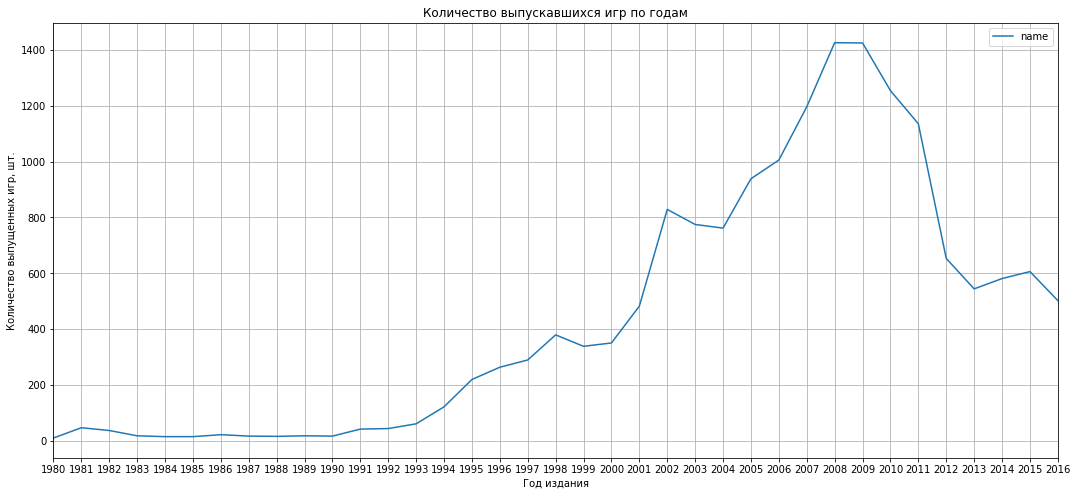

In [12]:
data.pivot_table(index='year_of_release', values='name', aggfunc='count').plot(figsize=(18,8), grid=True)
plt.title('Количество выпускавшихся игр по годам')
plt.xlabel('Год издания')
plt.ylabel('Количество выпущенных игр, шт.')
plt.xticks(np.arange(1980,2017,1))
plt.show()

### Вывод

Пик продаваемости видеоигр приходится на 2006-2011 года. После 2011 года продаваемость игр резко упала вдвое и с 2012 года держится примерно на одном уровне равном 500-600 млн. экземпляров в год

## Продажи по платформам

Посмотрим, сколько игр продавалось для каждой платформы

,total_sales
platform,
PS2,1233.56
X360,961.24
PS3,931.34
Wii,891.18
DS,802.78
PS,727.58
PS4,314.14
GBA,312.88
PSP,289.53


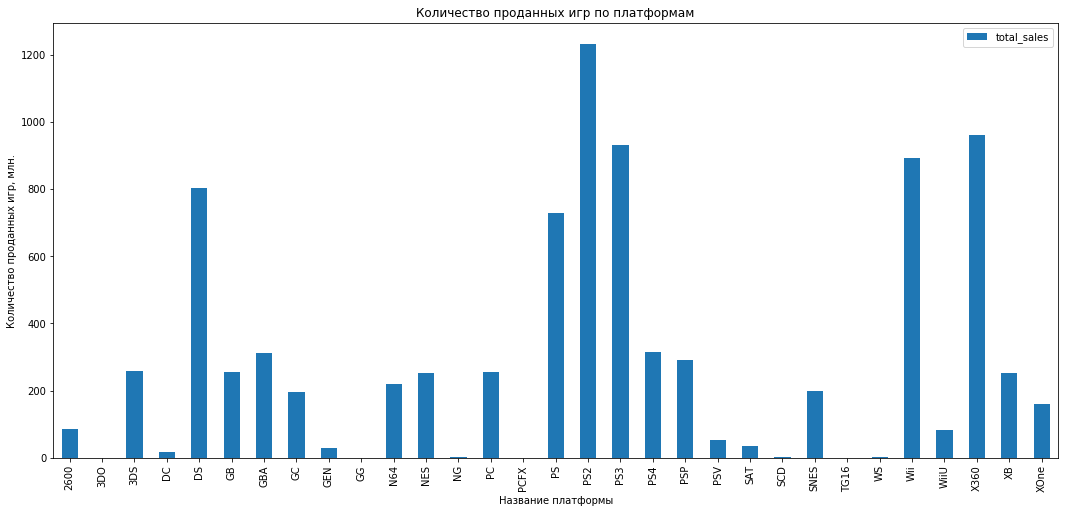

In [13]:
display(data.pivot_table(index='platform', values='total_sales', aggfunc='sum').sort_values(by='total_sales', ascending=False))
data.pivot_table(index='platform', values='total_sales', aggfunc='sum').plot(kind='bar',figsize=(18,8))
plt.title('Количество проданных игр по платформам')
plt.xlabel('Название платформы')
plt.ylabel('Количество проданных игр, млн.')
plt.show()

Разобьем платформы с количеством проданых игр > 50 млн. по производителям. Не будем учитывать платформу 2600, т.к. она существовала только до 1984 года

In [14]:
sony = data.query('platform == "PS2" or platform == "PS3" or platform == "PS" or platform == "PS4" or platform == "PSP" or platform == "PSV"').reset_index(drop=True)
nintendo = data.query('platform == "Wii" or platform == "DS" or platform == "3DS" or platform == "NES" or platform == "N64" or platform == "SNES" or platform == "GC"  or platform == "WiiU"').reset_index(drop=True)
microsoft = data.query('platform == "X360" or platform == "XB" or platform == "XOne"').reset_index(drop=True)
game_boy = data.query('platform == "GBA" or platform == "GB"').reset_index(drop=True)
pc = data.query('platform == "PC"').reset_index(drop=True)

Создадим датафреймы с продажами игр для каждой платформы по годам

In [15]:
sony_sales_annually = sony.pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum')
nintendo_sales_annually = nintendo.pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum')
microsoft_sales_annually = microsoft.pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum')
game_boy_sales_annually = game_boy.pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum')
pc_sales_annually = pc.pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum')
total_sales_annually = data.pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')

Построим графики продаж игр для каждой платформы по годам

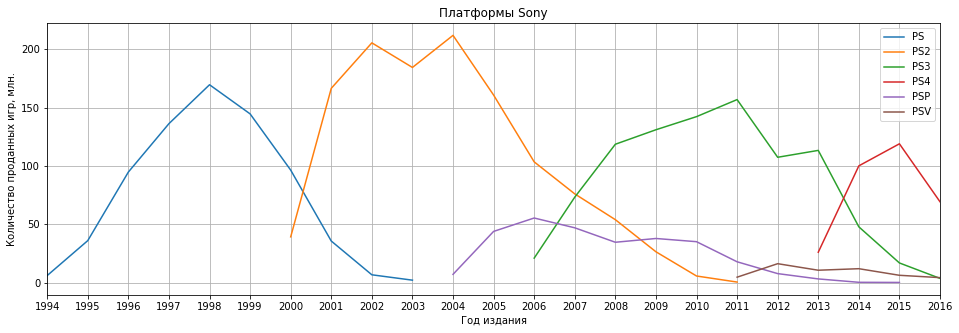

In [16]:
for column in sony_sales_annually.columns:
    sony_sales_annually[column].plot(legend=True, label=column, title='Платформы Sony',figsize=(16,5), grid=True)
plt.xlabel('Год издания')
plt.ylabel('Количество проданных игр, млн.')
plt.xticks(np.arange(1994,2017,1))
plt.show()

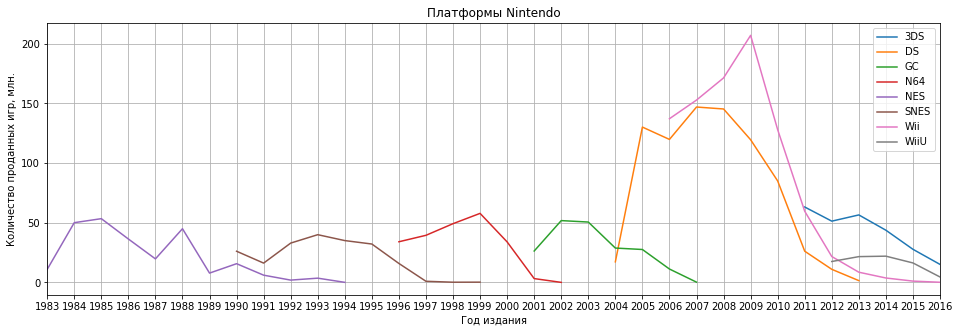

In [17]:
for column in nintendo_sales_annually.columns:
    nintendo_sales_annually[column].plot(legend=True, label=column, title='Платформы Nintendo',figsize=(16,5), grid=True)
plt.xlabel('Год издания')
plt.ylabel('Количество проданных игр, млн.')
plt.xticks(np.arange(1983,2017,1))
plt.show()

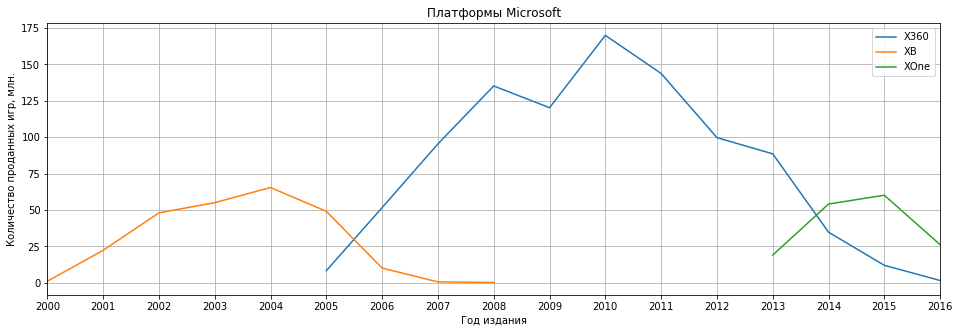

In [18]:
for column in microsoft_sales_annually.columns:
    microsoft_sales_annually[column].plot(legend=True, label=column, title='Платформы Microsoft',figsize=(16,5), grid=True)
plt.xlabel('Год издания')
plt.ylabel('Количество проданных игр, млн.')
plt.xticks(np.arange(2000,2017,1))
plt.show()

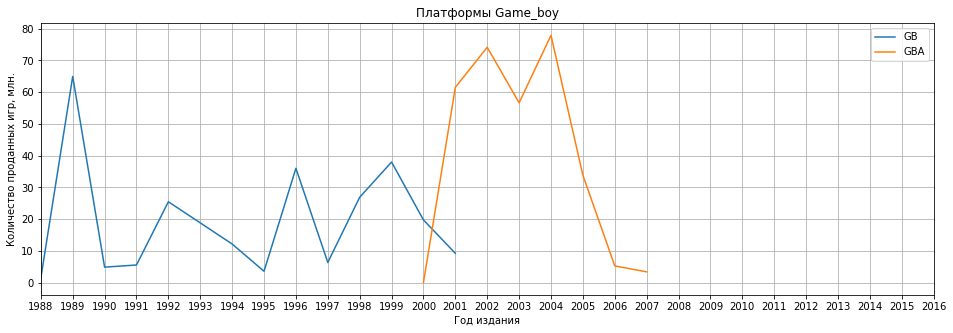

In [19]:
for column in game_boy_sales_annually.columns:
    game_boy_sales_annually[column].plot(legend=True, label=column, title='Платформы Game_boy',figsize=(16,5), grid=True)
plt.xlabel('Год издания')
plt.ylabel('Количество проданных игр, млн.')
plt.xticks(np.arange(1988,2017,1))
plt.show()

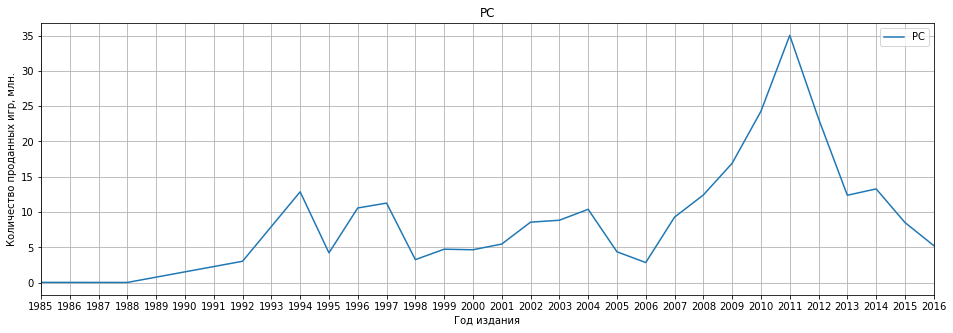

In [20]:
for column in pc_sales_annually.columns:
    pc_sales_annually[column].plot(legend=True, label=column, title='PC',figsize=(16,5), grid=True)
plt.xlabel('Год издания')
plt.ylabel('Количество проданных игр, млн.')
plt.xticks(np.arange(1985,2017,1))
plt.show()

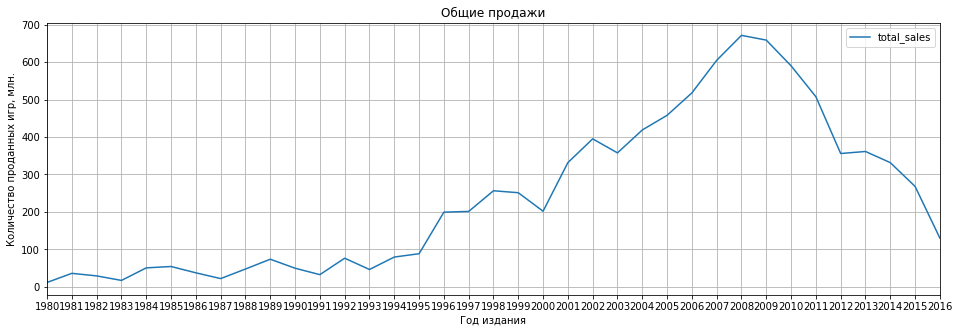

In [21]:
total_sales_annually.plot(legend=True, label=column, title='Общие продажи',figsize=(16,5), grid=True)
plt.xlabel('Год издания')
plt.ylabel('Количество проданных игр, млн.')
plt.xticks(np.arange(1980,2017,1))
plt.show()

### Вывод

Продажи игр на PC имеют тенденцию, похожую на общие продажи игр. Игры на PC остаются актуальными.

В 2016 году платформы: "PS3", "X360", "Wii" ещё существуют на рынке, однако находятся на завершающем этапе своего существования, и продажи игр для этих платформ стремятся к нулю. Актуальными платформами в 2016 на рынке остаются только следующие платформы: "XOne", "3DS", "WiiU", "PS4", "PSV", они же являются потенциально прибыльными. Следовательно **актуальный период** для рассмотрения - период сущестовования этих платформ, т.е. 2011г и позже. Данные за года ранее 2011 учитывать не следует при составлении прогноза на 2017 год.

## Продолжительность жизни платформы

Рассчиттаем среднюю продолжительность жизни платформы для платформ с количеством проданных игр > 50 млн. 

Платформа DS, выпущенная в 2004 году имеет минимальный год упоминания 1985. Это ошибка в данных. Найдем предварительно эту ошибку и удалим.

PC по факту не является игровой платформой и существует на рынке всё время существования игровой индустрии, поэтому исключим его из расчетов средней продолжительноти жизни платформы.

Так же, удалим из расчетов новые платформы, которые являются актуальными на текущий год.

In [22]:
print(data[(data['platform'] == "DS") & (data['year_of_release'] == 1985)])
data = data.drop(index=[15957])

                                      name platform  year_of_release   genre  \
15957  Strongest Tokyo University Shogi DS       DS             1985  Action   

       na_sales  eu_sales  jp_sales  other_sales  critic_score  user_score  \
15957       0.0       0.0      0.02          0.0           NaN         NaN   

      rating  total_sales  
15957    NaN         0.02  


,total_sales_sum,year_of_release_max,year_of_release_min,lifetime
platform,,,,
2600,86.48,1989,1980,9
DS,802.76,2013,2004,9
GB,254.43,2001,1988,13
GBA,312.88,2007,2000,7
GC,196.73,2007,2001,6
N64,218.01,2002,1996,6
NES,251.05,1994,1983,11
PS,727.58,2003,1994,9
PS2,1233.56,2011,2000,11


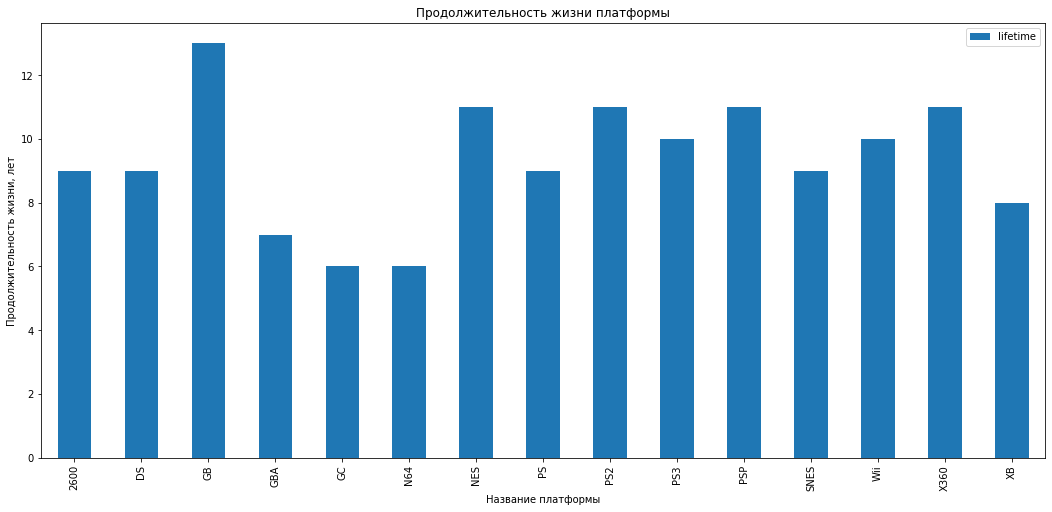

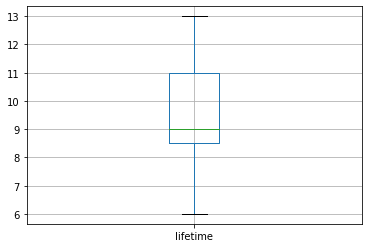

Средняя продолжительность жизни платформы равна 9.3 лет
Медианная продолжительность жизни платформы равна 9.0 лет


In [23]:
sorted_platforms = data.pivot_table(index='platform', values='total_sales', aggfunc='sum')
lifetime_of_platform = data.pivot_table(
    index='platform', 
    values=['year_of_release', 'total_sales'], 
    aggfunc={'year_of_release': ['min', 'max'], 'total_sales': sum}
)
lifetime_of_platform.columns = ['total_sales_sum', 'year_of_release_max', 'year_of_release_min']
lifetime_of_platform = lifetime_of_platform.query('total_sales_sum > 50 and index not in ["PC", "XOne", "3DS", "WiiU", "PS4", "PSV"]')
lifetime_of_platform['lifetime'] = lifetime_of_platform['year_of_release_max'] - lifetime_of_platform['year_of_release_min']
display(lifetime_of_platform)

lifetime_of_platform.plot(y='lifetime', kind='bar', figsize=(18,8))
plt.title('Продолжительность жизни платформы')
plt.xlabel('Название платформы')
plt.ylabel('Продолжительность жизни, лет')
plt.show()

lifetime_of_platform.boxplot('lifetime')
plt.show()

print('Средняя продолжительность жизни платформы равна {:.1f} лет'.format(lifetime_of_platform['lifetime'].mean()))
print('Медианная продолжительность жизни платформы равна {:.1f} лет'.format(lifetime_of_platform['lifetime'].median()))


Выбросов по продолжительности жизни платформ нет.

### Вывод

Средний срок жизни платформы составляет 9 лет. Пик продаж приходится на середину жизненного цикла. При этом, первый этап жизненного цикла платформы состовляет примерно 2 года, в это время ещё не уходит с рынка предыдущая версия, поэтому продажи старой версии продолжают падать, а новой - растут; второй и третий этапы составляют 5-6 лет - в это время у каждого производителя на рынке есть одна топовая платформа, половину этого времени она продолжает развиваться, и продажи игр растут, а вторую половину времени продажи игр падают; четвёртый этап жизни платформы - когда выпускают новую платформу, пользователи начинают постепенно переходить на новую версию, продажи существующей стремительно падают.

## Продажи по актуальным платформам

Создадим датасет, состоящий из актуальных платформ за актуальный период. Построим диаграммы размаха по количеству проданных копий каждой игры для каждой из актуальных платформ.

In [24]:
actual_data = data.query('year_of_release >= 2011 and (platform == "XOne" or platform == "3DS" or platform == "WiiU" or platform == "PS4" or platform == "PSV"or platform == "PC")')

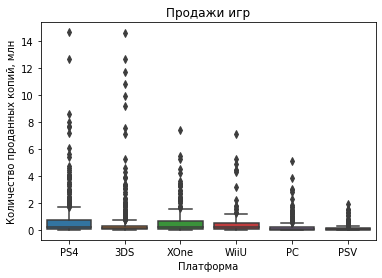

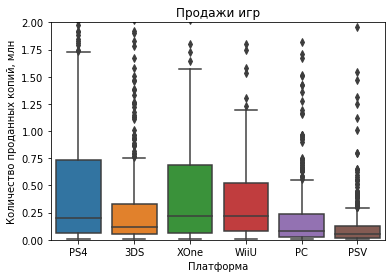

In [25]:
sns.boxplot(x='platform', y='total_sales', data=actual_data)
plt.title('Продажи игр')
plt.xlabel('Платформа')
plt.ylabel('Количество проданных копий, млн')
plt.show()

plt.ylim(0, 2)
sns.boxplot(x='platform', y='total_sales', data=actual_data)
plt.title('Продажи игр')
plt.xlabel('Платформа')
plt.ylabel('Количество проданных копий, млн')
plt.show()

Можно заметить, что медианное количество продаваемых копий одной игры весьма небольшое для каждой платформы ~0,25 млн. копий. Для большинства игр количество проданых копий на любой платформе не превышает 1,75 млн. В то же время у всех платформ есть аномальные значения - игры, продажи которых в 20-50 раз превосходят медианное значение по количеству продаж.

Так же, можно заметить различие между продажами игр на домашние платформы и на портативные. Медианные значения больших отличий не имеют, однако 3-ий и 4-ый квартили значений продаж игр на портативные платформы значительно ниже чем у домашних платформ.

## Влияние отзывов на продажи

Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами.

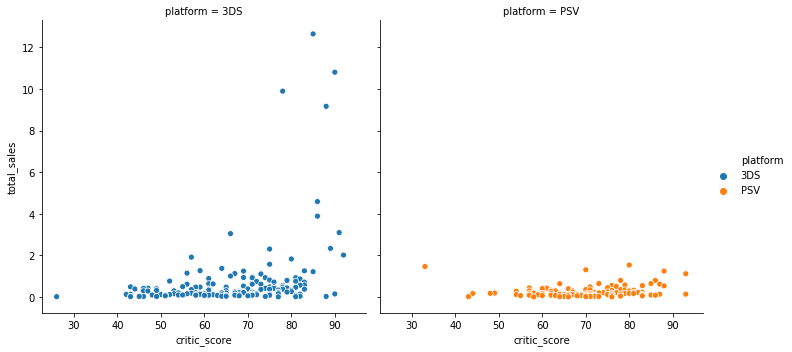

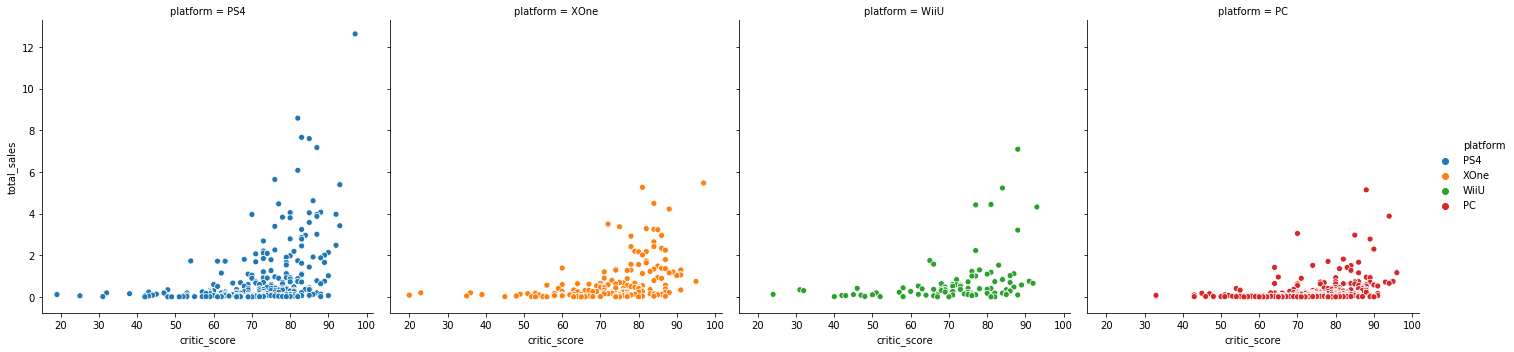

Корреляция оценки критиков и числа продаваемых копий игр для платформы PS4 составляет 0.4
Корреляция оценки критиков и числа продаваемых копий игр для платформы XOne составляет 0.4
Корреляция оценки критиков и числа продаваемых копий игр для платформы WiiU составляет 0.3
Корреляция оценки критиков и числа продаваемых копий игр для платформы 3DS составляет 0.3
Корреляция оценки критиков и числа продаваемых копий игр для платформы PSV составляет 0.1
Корреляция оценки критиков и числа продаваемых копий игр для платформы PC составляет 0.3


In [26]:
actual_data_portable = actual_data.query('platform == "3DS" or platform == "PSV"')
actual_data_home = actual_data.query('platform == "PS4" or platform == "XOne" or platform == "WiiU" or platform == "PC"')

sns.relplot(x='critic_score', y='total_sales',col='platform', hue='platform', data=actual_data_portable)
plt.show()

sns.relplot(x='critic_score', y='total_sales',col='platform', hue='platform', data=actual_data_home)
plt.show()

print('Корреляция оценки критиков и числа продаваемых копий игр для платформы PS4 составляет {:.1f}'.format(actual_data[actual_data['platform'] == "PS4"]['critic_score'].corr(actual_data[actual_data['platform'] == "PS4"]['total_sales'])))
print('Корреляция оценки критиков и числа продаваемых копий игр для платформы XOne составляет {:.1f}'.format(actual_data[actual_data['platform'] == "XOne"]['critic_score'].corr(actual_data[actual_data['platform'] == "XOne"]['total_sales'])))
print('Корреляция оценки критиков и числа продаваемых копий игр для платформы WiiU составляет {:.1f}'.format(actual_data[actual_data['platform'] == "WiiU"]['critic_score'].corr(actual_data[actual_data['platform'] == "WiiU"]['total_sales'])))
print('Корреляция оценки критиков и числа продаваемых копий игр для платформы 3DS составляет {:.1f}'.format(actual_data[actual_data['platform'] == "3DS"]['critic_score'].corr(actual_data[actual_data['platform'] == "3DS"]['total_sales'])))
print('Корреляция оценки критиков и числа продаваемых копий игр для платформы PSV составляет {:.1f}'.format(actual_data[actual_data['platform'] == "PSV"]['critic_score'].corr(actual_data[actual_data['platform'] == "PSV"]['total_sales'])))
print('Корреляция оценки критиков и числа продаваемых копий игр для платформы PC составляет {:.1f}'.format(actual_data[actual_data['platform'] == "PC"]['critic_score'].corr(actual_data[actual_data['platform'] == "PC"]['total_sales'])))

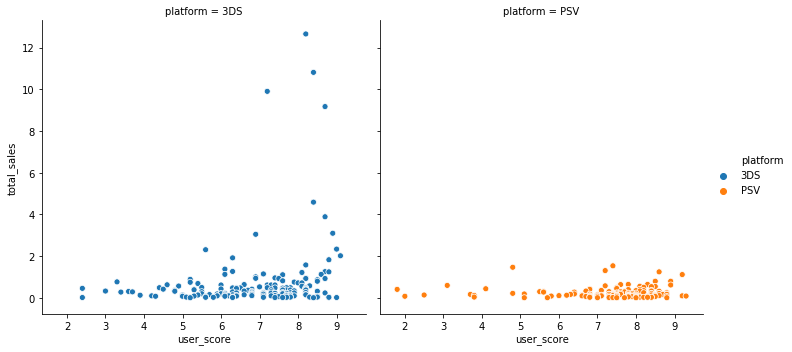

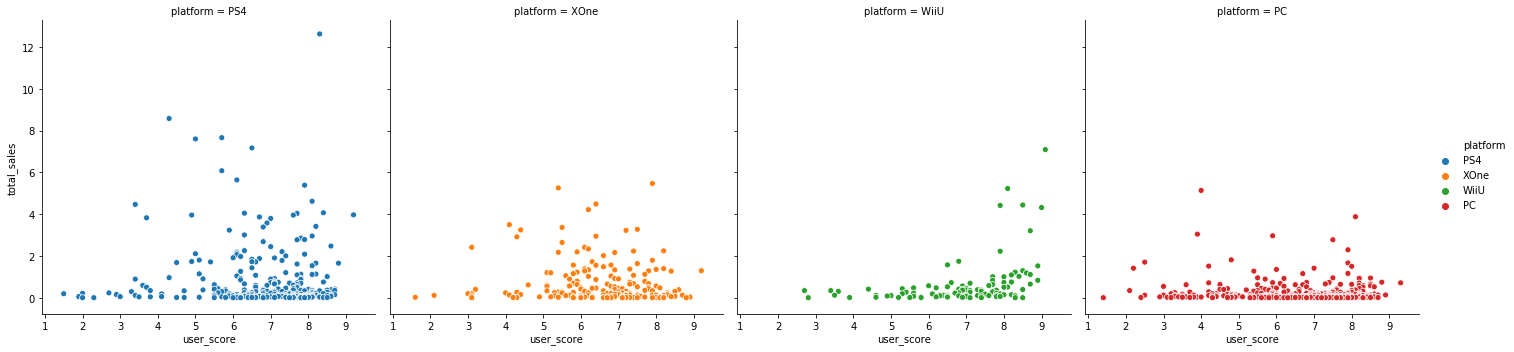

Корреляция оценки пользователей и числа продаваемых копий игр для платформы PS4 составляет -0.0
Корреляция оценки пользователей и числа продаваемых копий игр для платформы XOne составляет -0.1
Корреляция оценки пользователей и числа продаваемых копий игр для платформы WiiU составляет 0.4
Корреляция оценки пользователей и числа продаваемых копий игр для платформы 3DS составляет 0.2
Корреляция оценки пользователей и числа продаваемых копий игр для платформы PSV составляет 0.0
Корреляция оценки пользователей и числа продаваемых копий игр для платформы PC составляет -0.0


In [27]:
sns.relplot(x='user_score', y='total_sales',col='platform', hue='platform', data=actual_data_portable)
plt.show()

sns.relplot(x='user_score', y='total_sales',col='platform', hue='platform', data=actual_data_home)
plt.show()

print('Корреляция оценки пользователей и числа продаваемых копий игр для платформы PS4 составляет {:.1f}'.format(actual_data[actual_data['platform'] == "PS4"]['user_score'].corr(actual_data[actual_data['platform'] == "PS4"]['total_sales'])))
print('Корреляция оценки пользователей и числа продаваемых копий игр для платформы XOne составляет {:.1f}'.format(actual_data[actual_data['platform'] == "XOne"]['user_score'].corr(actual_data[actual_data['platform'] == "XOne"]['total_sales'])))
print('Корреляция оценки пользователей и числа продаваемых копий игр для платформы WiiU составляет {:.1f}'.format(actual_data[actual_data['platform'] == "WiiU"]['user_score'].corr(actual_data[actual_data['platform'] == "WiiU"]['total_sales'])))
print('Корреляция оценки пользователей и числа продаваемых копий игр для платформы 3DS составляет {:.1f}'.format(actual_data[actual_data['platform'] == "3DS"]['user_score'].corr(actual_data[actual_data['platform'] == "3DS"]['total_sales'])))
print('Корреляция оценки пользователей и числа продаваемых копий игр для платформы PSV составляет {:.1f}'.format(actual_data[actual_data['platform'] == "PSV"]['user_score'].corr(actual_data[actual_data['platform'] == "PSV"]['total_sales'])))
print('Корреляция оценки пользователей и числа продаваемых копий игр для платформы PC составляет {:.1f}'.format(actual_data[actual_data['platform'] == "PC"]['user_score'].corr(actual_data[actual_data['platform'] == "PC"]['total_sales'])))

### Вывод

Наблюдается слабая корреляциця оценки критиков и продаваемости игр на всех платформах, кроме PSV.

Оценка пользователей на продаваемость игр никак не влияет, лишь небольшая корреляция есть между этими величинами для платформы WiiU

## Влияние жанра на продажи

In [28]:
actual_data_genre = actual_data.pivot_table(index='genre', values='total_sales', aggfunc='sum')

display(actual_data_genre.sort_values(by='total_sales', ascending=False))

,total_sales
genre,
Action,246.88
Shooter,182.92
Role-Playing,161.46
Sports,101.46
Platform,65.56
Racing,49.34
Misc,44.27
Simulation,41.26
Fighting,30.67


### Вывод

Самые высокие продажи у жанров Action и Shooter, которые по своей сути похожи, оба представляют из себя линейную игру, в которой многое зависит от физических навыков игрока(скорость реакции, координация и т.д.). Так же достаточно высокие продажи у ролевых игр и у спортивных. Наименьшие продажи у игр, над которыми надо подумать и где минимальное количество анимации и действия - это стратегии и головоломки.

## 4. Портрет пользователя по регионам

## Платформы

Определим 5 самых популярных платформ для пользователей каждого региона

,eu_sales,jp_sales,na_sales
platform,,,
PS4,141.09,15.96,108.74
3DS,61.27,100.62,82.65
PC,56.70,0.00,29.88
XOne,51.59,0.34,93.12
WiiU,25.13,13.01,38.10
PSV,13.07,21.84,12.47


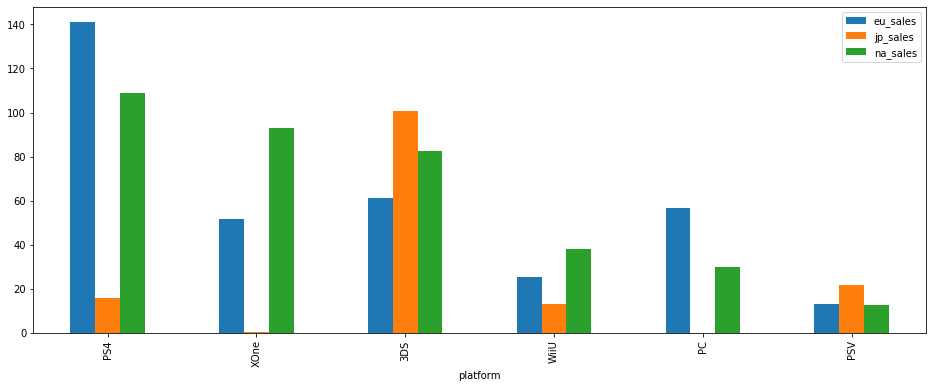

In [46]:
actual_data_platform_regions = actual_data.pivot_table(index='platform', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='sum')
display(actual_data_platform_regions.sort_values(by='eu_sales', ascending=False))
actual_data_platform_regions.sort_values(by='na_sales', ascending=False).plot(kind='bar', figsize=(16,6))
plt.xlabel('Платформа')
plt.ylabel('Количество проданых копий, млн.')
plt.title('Продажи игр по платформам в регионах')
plt.show()

У Европейцев и Американцев рынок платформ похож. Предпочтение одтается полноразмерным домашним платформам PS4, так же достаточно много продается игр на XOne и PC. WiiU пользуется наименьшей популярностью среди полноразмерных платформ. В обоих регионах пользователи отдают предпочтение платформе 3DS среди портативных платформ.

В Японии по каким-то причинам полностью отсутствуют игры на PC, и очень мало игр на домашние платформы. А продаваемость игр на портативные платформы превосходит другие регионы почти в 1,5 раза. Среди портативных платформ предпочтение во всех регионах отдается платформе 3DS

## Жанры

Определим самые популярные жанры среди пользователей каждого региона

,eu_sales,jp_sales,na_sales
genre,,,
Action,90.21,36.54,93.41
Shooter,72.92,4.95,81.82
Sports,43.66,4.54,40.04
Role-Playing,42.91,54.19,52.00
Platform,22.30,10.71,26.97
Racing,22.04,4.60,17.72
Simulation,17.50,10.64,10.43
Misc,12.70,10.70,17.18
Fighting,7.87,5.67,14.05


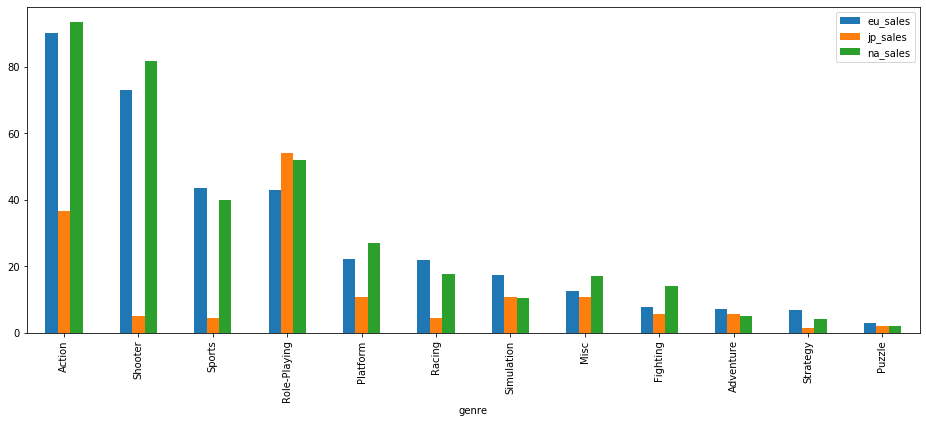

In [44]:
actual_data_genre_regions = actual_data.pivot_table(index='genre', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='sum')
display(actual_data_genre_regions.sort_values(by='eu_sales', ascending=False))
actual_data_genre_regions.sort_values(by='eu_sales', ascending=False).plot(kind='bar', figsize=(16,6))
plt.xlabel('Жанр')
plt.ylabel('Количество проданых копий, млн.')
plt.title('Продажи игр по жанрам в регионах')
plt.show()

Предпочтения по жанрам почти полностью совпадают у пользователей Европы и Америки. Лидирующие позиции занимают Shooter и Action.

В Японии совсем другая картина. Первую строку занимают ролевые игры, на второй находится Action, а вот Shooter в Японии продается очень мало, как и Sports. 3,4 и 5 места делят Platform, Simulation, Misc.

## Рейтинг ESRB

Проверим влияние рейтинга ESRB на продажи в регионах

В столбце с этим рейтингом много пропусков. Чтобы не потерять данные, заполним пропуски, отметив, что у этих игр нет рейтинга ESRB.

In [48]:
actual_data['rating'] = actual_data['rating'].fillna('no rating')

,eu_sales,jp_sales,na_sales
rating,,,
M,113.17,9.28,112.22
E,81.66,29.76,81.14
no rating,75.65,87.91,78.86
T,44.61,16.50,47.85
E10+,33.73,8.32,44.89
RP,0.03,0.00,0.00


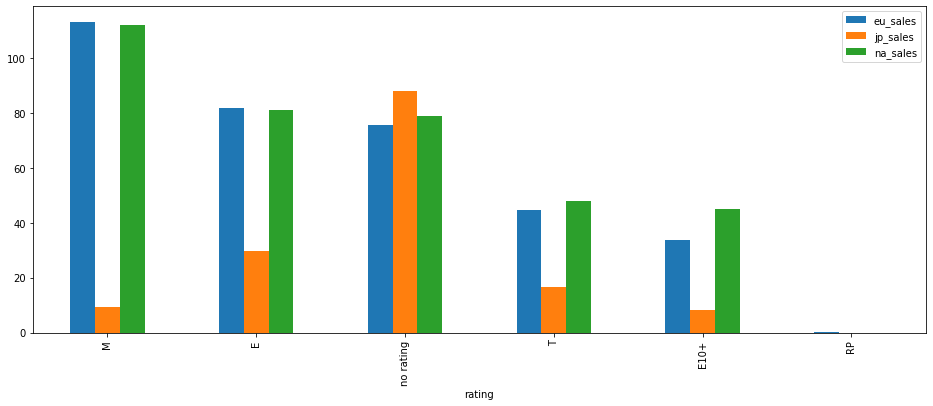

In [51]:
actual_data_esrb_regions = actual_data.pivot_table(index='rating', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='sum')
display(actual_data_esrb_regions.sort_values(by='eu_sales', ascending=False))
actual_data_esrb_regions.sort_values(by='eu_sales', ascending=False).plot(kind='bar', figsize=(16,6))
plt.xlabel('Рейтинг ESRB')
plt.ylabel('Количество проданых копий, млн.')
plt.title('Продажи игр по платформам в регионах')
plt.show()

В Европе и Америке активно продаются игры всех возрастных категорий, особенно 17+. В Японии больше всего продаются игры без ограничений по возрасту пользователя, так же продается большой процент игр 14+ (для подростков). Игры для взрослых в Японии имеют небольшой процент продаж.

## 5. Проверка гипотез

Проверим следцющие гипотезы:
1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые
2. Средние пользовательские рейтинги жанров Action и Sports разные

## Гипотеза 1

Создадим два датасета, включающих в себя данные для платформ XOne и PC соответственно

In [32]:
xone_data = actual_data.query('platform == "XOne"')
pc_data = actual_data.query('platform == "PC"')

xone_data.dropna(subset=['user_score'], inplace=True)
xone_data = xone_data.reset_index(drop=True)

pc_data.dropna(subset=['user_score'], inplace=True)
pc_data = pc_data.reset_index(drop=True)

Для проверки гипотез воспользуемся методом ttest из библиотеки scipy

Проверим соотношение дисперсий двух выборок, для дальнейшего определения параметра equal_var

In [33]:
print('Дисперсии выборок отличаются на {:.1%}'
      .format((max(np.var(xone_data['user_score']), np.var(pc_data['user_score']))
             - min(np.var(xone_data['user_score']), np.var(pc_data['user_score'])))
             / min(np.var(xone_data['user_score']), np.var(pc_data['user_score'])))
     )

Дисперсии выборок отличаются на 36.5%


Дисперсии отличаются значительно больше чем на 5%, значит параметр equal_var будет принимать значение False

Сформулируем нулевую гипотезу исходя из знака равенства: "Средние пользовательские рейтинги платформ Xbox One и PC равны между собой", тогда альтернативная гипотеза будет: "Средние пользовательские рейтинги платформ Xbox One и PC отличаются"

In [34]:
alpha = .05

results_1 = st.ttest_ind(xone_data['user_score'], pc_data['user_score'], equal_var=False)

print('p-value:', results_1.pvalue)

if results_1.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

p-value: 0.6130712247638477
Не отвергаем нулевую гипотезу


### Вывод

Не удалось отвергнуть нулевую гипотезу, а значит велика вероятность того, что наше предположение верно и средние пользовательские рейтинги платформ Xbox One и PC одинаковые

## Гипотеза 2

Создадим два датасета, включающих в себя данные для жанров Action и Sports соответственно

In [35]:
action_data = actual_data.query('genre == "Action"')
action_data.dropna(subset=['user_score'], inplace=True)

sports_data = actual_data.query('genre == "Sports"')
sports_data.dropna(subset=['user_score'], inplace=True)

Проверим соотношение дисперсий двух выборок, для дальнейшего определения параметра equal_var

In [36]:
print('Дисперсии выборок отличаются на {:.1%}'
      .format((max(np.var(action_data['user_score']), np.var(sports_data['user_score']))
             - min(np.var(action_data['user_score']), np.var(sports_data['user_score'])))
             / min(np.var(action_data['user_score']), np.var(sports_data['user_score'])))
     )

Дисперсии выборок отличаются на 45.6%


Дисперсии отличаются значительно больше чем на 5%, значит параметр equal_var будет принимать значение False

Сформулируем нулевую гипотезу исходя из знака равенства: "Средние пользовательские рейтинги жанров Action и Sports равны между собой", тогда альтернативная гипотеза будет: "Средние пользовательские рейтинги жанров Action и Sports отличаются"

In [37]:
alpha = .05

results_1 = st.ttest_ind(action_data['user_score'], sports_data['user_score'], equal_var=False)

print('p-value:', results_1.pvalue)

if results_1.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

p-value: 1.8972540670913242e-10
Отвергаем нулевую гипотезу


### Выовод

Мы отвергли нулевую гипотезу, но она звучала противоположно нашему предположению, значит высока вероятность что наше предположение верно и средние пользовательские рейтинги жанров Action и Sports разные

## 6. Общий вывод

В данной работе были исследованы данные о продаже видеоигр за всё время до 2016 года.

В результате исследования был определен жизненный цикл платформ. Исходя из него был определен актуальный период для рассмотрения с целью прогнозирования будущего года. Актуальным получился период с 2011 года. Весь дальнейший анализ производился для актуального периода.

Были выявлены: перспективные платформы на рынке("XOne", "3DS", "WiiU", "PS4", "PSV"), самые популярные жанры(Action, Shooter).

Было выявлено, что оценки пользователей никак не влияют на продажи игр, а оценки критиков имеют корреляцию с продажами больше, но всё ещё меньше 0.5

Были проанализированы продажи по регионам в отдельности. Евросоюз и Северная Америка имеют похожие предпочтения и тенденции, в то время как Япония отличается в предпочтении по платформам, по жанрам, и в Японии сильно ограничены продажи игр 17+.

Были проверены гипотезы и сделаны выводы о том, что средние оценки пользователей по жанрам Action и Sports отличаются; средние оценки пользователей по платформам XOne и PC скорее всего близки по значению.